In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

# Set seed
torch.manual_seed(0)

# Scheduler import
from torch.optim.lr_scheduler import StepLR


In [2]:
'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 128
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

 Веса инициализируются в момент опсиания архитектуры сети.
 Все возможные варианты инициализации весов приведены в официальной [документации](https://pytorch.org/docs/stable/nn.init.html). В примере ниже веса инициализируются методом Ксавье, что соотвествует использованию `tanh` в качестве функции активации

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/HSE_DL_2022/week_03

/content/gdrive/My Drive/HSE_DL_2022/week_03


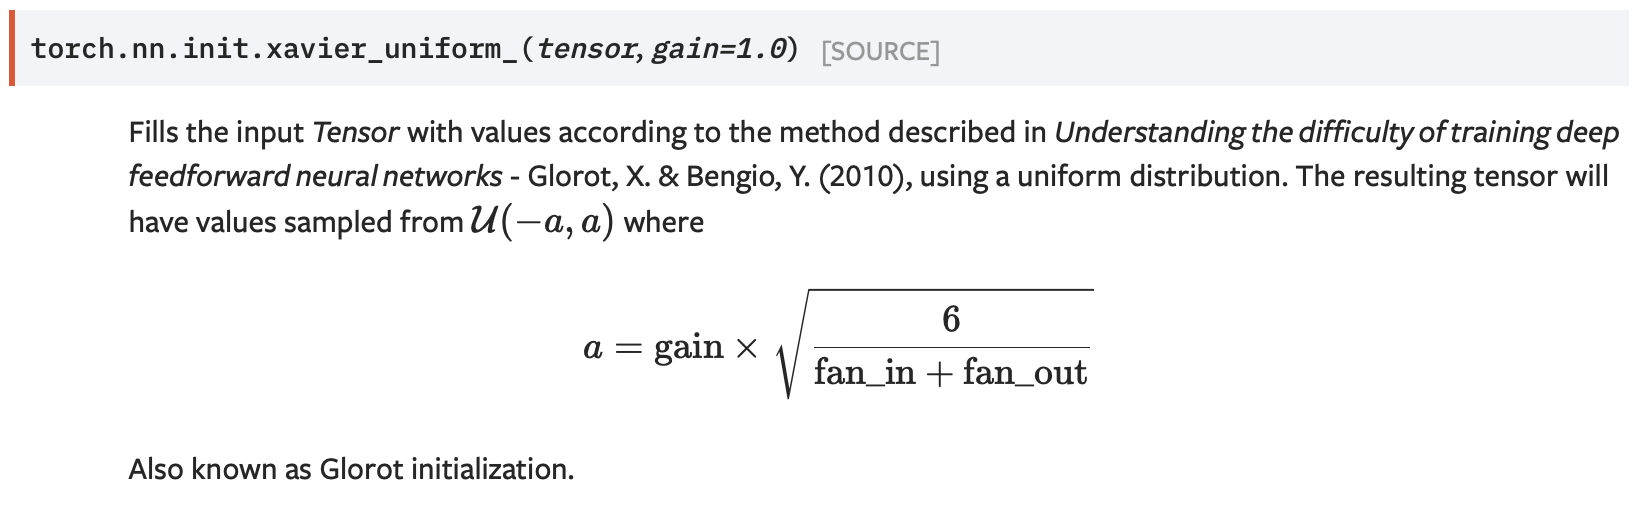

In [ ]:
from IPython import display
display.Image('xavier.png')

In [6]:
'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, act_type='relu', init_type='he'):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        
        # Non-linearity
        if act_type == 'tanh':
            self.activation = nn.Tanh()
        elif act_type == 'relu':
            self.activation = nn.ReLU()
        elif act_type == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            print('This kind of activation is not supported in this net')

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
        
        # Linear weight, W,  Y = WX + B
        if init_type == 'xavier':
            nn.init.xavier_normal_(self.fc1.weight)
            nn.init.xavier_normal_(self.fc2.weight)
        elif init_type == 'he':
            nn.init.kaiming_normal_(self.fc1.weight)
            nn.init.kaiming_normal_(self.fc2.weight)
        else:
            print('This kind of initialization is not supported in this net')

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.activation(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out

In [7]:
a = torch.empty(3,3)
print(a)
nn.init.xavier_normal_(a)

tensor([[1.7878e-35, 0.0000e+00, 1.4013e-45],
        [0.0000e+00,        nan, 0.0000e+00],
        [1.3235e-14, 3.6423e-06, 2.0699e-19]])


tensor([[-0.2329, -0.3445,  0.1051],
        [-0.4946,  0.6354, -0.6185],
        [ 0.0708, -0.3270,  0.2154]])

In [8]:
'''
STEP 4: INSTANTIATE BASE PARAMETERS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

In [9]:
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

In [10]:
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

In [11]:
'''
STEP 7: INSTANTIATE STEP LEARNING SCHEDULER CLASS
'''
# step_size: at how many multiples of epoch you decay
# step_size = 1, after every 1 epoch, new_lr = lr*gamma 
# step_size = 2, after every 2 epoch, new_lr = lr*gamma 

# gamma = decaying factor
scheduler = StepLR(optimizer, step_size=1, gamma=0.96)


In [12]:
'''
STEP 8: TRAIN THE MODEL
'''
def model_train(model, criterion, optimizer, scheduler, train_loader, test_loader):
    iter = 0
    for epoch in range(num_epochs):
        # Print Learning Rate
        print('Epoch:', epoch,'LR:', scheduler.get_last_lr()[0])
        for i, (images, labels) in enumerate(train_loader):
            # Load images as tensors with gradient accumulation abilities
            images = images.view(-1, 28*28).requires_grad_()

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            iter += 1

            if iter % 500 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                for images, labels in test_loader:
                    # Load images to a Torch Variable
                    images = images.view(-1, 28*28)

                    # Forward pass only to get logits/output
                    outputs = model(images)

                    # Get predictions from the maximum value
                    _, predicted = torch.max(outputs.data, 1)

                    # Total number of labels
                    total += labels.size(0)

                    # Total correct predictions
                    correct += (predicted.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum()

                accuracy = 100. * correct.item() / total

                # Print Loss
                print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

        # Decay Learning Rate
        scheduler.step()

## ReLU + Xavier

In [13]:
model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim, act_type='relu', init_type='xavier')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = StepLR(optimizer, step_size=1, gamma=0.96)

model_train(model, criterion, optimizer, scheduler, train_loader, test_loader)

Epoch: 0 LR: 0.1
Epoch: 1 LR: 0.096
Iteration: 500. Loss: 0.14689739048480988. Accuracy: 96.37
Epoch: 2 LR: 0.09215999999999999
Iteration: 1000. Loss: 0.05357832461595535. Accuracy: 96.91
Epoch: 3 LR: 0.08847359999999999
Iteration: 1500. Loss: 0.05807765945792198. Accuracy: 97.47
Epoch: 4 LR: 0.08493465599999998
Iteration: 2000. Loss: 0.1308586597442627. Accuracy: 97.39
Epoch: 5 LR: 0.08153726975999998
Iteration: 2500. Loss: 0.026700986549258232. Accuracy: 97.8


## Sigmoid + Xavier


In [14]:
model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim, act_type='sigmoid', init_type='xavier')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = StepLR(optimizer, step_size=1, gamma=0.96)

model_train(model, criterion, optimizer, scheduler, train_loader, test_loader)

Epoch: 0 LR: 0.1
Epoch: 1 LR: 0.096
Iteration: 500. Loss: 0.2125803381204605. Accuracy: 92.9
Epoch: 2 LR: 0.09215999999999999
Iteration: 1000. Loss: 0.19734057784080505. Accuracy: 94.36
Epoch: 3 LR: 0.08847359999999999
Iteration: 1500. Loss: 0.14967948198318481. Accuracy: 95.32
Epoch: 4 LR: 0.08493465599999998
Iteration: 2000. Loss: 0.2313624918460846. Accuracy: 95.97
Epoch: 5 LR: 0.08153726975999998
Iteration: 2500. Loss: 0.11756680905818939. Accuracy: 96.34


## Tanh + Xavier


In [15]:
model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim, act_type='tanh', init_type='xavier')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = StepLR(optimizer, step_size=1, gamma=0.96)

model_train(model, criterion, optimizer, scheduler, train_loader, test_loader)

Epoch: 0 LR: 0.1
Epoch: 1 LR: 0.096
Iteration: 500. Loss: 0.0903572365641594. Accuracy: 95.67
Epoch: 2 LR: 0.09215999999999999
Iteration: 1000. Loss: 0.016621803864836693. Accuracy: 96.77
Epoch: 3 LR: 0.08847359999999999
Iteration: 1500. Loss: 0.05794503912329674. Accuracy: 97.16
Epoch: 4 LR: 0.08493465599999998
Iteration: 2000. Loss: 0.05637215077877045. Accuracy: 97.42
Epoch: 5 LR: 0.08153726975999998
Iteration: 2500. Loss: 0.033508315682411194. Accuracy: 97.51


## ReLU + He


In [16]:
model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim, act_type='relu', init_type='he')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = StepLR(optimizer, step_size=1, gamma=0.96)

model_train(model, criterion, optimizer, scheduler, train_loader, test_loader)


Epoch: 0 LR: 0.1
Epoch: 1 LR: 0.096
Iteration: 500. Loss: 0.13843341171741486. Accuracy: 96.11
Epoch: 2 LR: 0.09215999999999999
Iteration: 1000. Loss: 0.06506385654211044. Accuracy: 97.0
Epoch: 3 LR: 0.08847359999999999
Iteration: 1500. Loss: 0.03003709763288498. Accuracy: 97.38
Epoch: 4 LR: 0.08493465599999998
Iteration: 2000. Loss: 0.03996916115283966. Accuracy: 97.52
Epoch: 5 LR: 0.08153726975999998
Iteration: 2500. Loss: 0.07212337106466293. Accuracy: 97.66


## Sigmoid + He


In [17]:
model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim, act_type='sigmoid', init_type='he')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = StepLR(optimizer, step_size=1, gamma=0.96)

model_train(model, criterion, optimizer, scheduler, train_loader, test_loader)


Epoch: 0 LR: 0.1
Epoch: 1 LR: 0.096
Iteration: 500. Loss: 0.311854749917984. Accuracy: 92.57
Epoch: 2 LR: 0.09215999999999999
Iteration: 1000. Loss: 0.13268324732780457. Accuracy: 94.21
Epoch: 3 LR: 0.08847359999999999
Iteration: 1500. Loss: 0.12646065652370453. Accuracy: 95.33
Epoch: 4 LR: 0.08493465599999998
Iteration: 2000. Loss: 0.09303253144025803. Accuracy: 95.92
Epoch: 5 LR: 0.08153726975999998
Iteration: 2500. Loss: 0.07185272872447968. Accuracy: 96.37


## Tanh + He


In [18]:
model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim, act_type='tanh', init_type='he')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = StepLR(optimizer, step_size=1, gamma=0.96)

model_train(model, criterion, optimizer, scheduler, train_loader, test_loader)


Epoch: 0 LR: 0.1
Epoch: 1 LR: 0.096
Iteration: 500. Loss: 0.14974017441272736. Accuracy: 95.66
Epoch: 2 LR: 0.09215999999999999
Iteration: 1000. Loss: 0.025834187865257263. Accuracy: 96.8
Epoch: 3 LR: 0.08847359999999999
Iteration: 1500. Loss: 0.06368228048086166. Accuracy: 97.24
Epoch: 4 LR: 0.08493465599999998
Iteration: 2000. Loss: 0.03554287552833557. Accuracy: 97.27
Epoch: 5 LR: 0.08153726975999998
Iteration: 2500. Loss: 0.02198537439107895. Accuracy: 97.55


[Источник](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/weight_initialization_activation_functions/) ноутбука